<p style="display:flex; align-items:center;">
  <img src="https://upload.wikimedia.org/wikipedia/it/1/11/Napoli_university_seal_alfachannel.png"
       alt="Logo UNINA" width="10%" style="margin-right:2%;">
  <img src="https://indico.unina.it/event/58/attachments/172/352/logo_dieti.png"
       alt="Logo DIETI" width="10%">
</p>


# Hierarchical Intrusion Detection

---

***Practical Network Intrusion Detection with Machine Learning and Generative AI***

Prof. Giampaolo Bovenzi


In [ ]:
# Colab bootstrap
import os, sys, subprocess, importlib, pathlib

REPO_URL = "https://github.com/jmpr0/practical-nids"
REPO_DIR = "/content/practical-nids"

if not pathlib.Path(REPO_DIR).exists():
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install deps
subprocess.run([sys.executable, "-m", "pip", "install", "-r", "/content/practical-nids/requirements.txt", "--quiet"], check=True)

# Create outputs dirs
for d in ["outputs", "data/cache", "models"]:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

print("Setup OK in", os.getcwd())


## Library imports

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import os

In [115]:
data_dir = '../dataset/CICAndMal2017'

In [116]:
# from glob import glob


# def downsample_data(data_dir):
#     fns = glob(f"{data_dir}/Family/*/*.json")
#     for fn in fns:
#         with open(fn, "r") as f:
#             data = json.load(f)
#         keys = list(data.keys())
#         if len(keys) > 100:
#             keys = np.random.choice(keys, 100, replace=False)
#             new_data = {k: data[k] for k in keys}
#             with open(fn.replace('.json', '_100smpl.json'), "w") as f:
#                 json.dump(new_data, f, indent=4)
#     print("Downsampling completed.")

# downsample_data(data_dir)

In [117]:
# def merge_families(data_dir):
#     fns = glob(f"{data_dir}/Family/*/*_100smpl.json")
#     data_per_category = {}
#     for fn in fns:
#         category = fn.split('/')[-2]
#         with open(fn, "r") as f:
#             data = json.load(f)
#         data_per_category.setdefault(category, {}).update(data)

#     for category in data_per_category:
#         with open(f"{data_dir}/Category/{category}_100smplXfam.json", "w") as f:
#             json.dump(data_per_category[category], f, indent=4)
    
#     print("Merging completed.")

# merge_families(data_dir)

In [118]:
# d = json.load(open(f"{data_dir}/Category/Benign.json"))

# keys = list(d.keys())
# keys = np.random.choice(keys, 4200, replace=False)

# new_data = {k: d[k] for k in keys}

# with open(f"{data_dir}/Category/Benign_4200smpl.json", "w") as f:
#     json.dump(new_data, f, indent=4)

## Data Loader Module
This module handles loading and preprocessing of datasets for misuse detection.

In [ ]:
def load_json(level="binary"):
    categories = ["SMSMalware", "Ransomware", "Adware", "Scareware"]
    features = [
        "pkt_length", "iat", "biflow_volume", "biflow_duration",
        "n_packets", "fwd_n_packets", "bwd_n_packets",
        "fwd_volume", "bwd_volume"
    ]

    json_data, data, target = {}, [], []

    def compute_stats(values):
        """Restituisce statistiche base e percentili su una lista di valori numerici."""
        if not values:
            return [0] * 10
        return [
            np.mean(values), np.max(values), np.min(values),
            np.percentile(values, 25), np.percentile(values, 75),
            np.percentile(values, 50), np.percentile(values, 60),
            np.percentile(values, 95), np.std(values), np.var(values)
        ]

    def build_file_list():
        """Costruisce la lista dei file da caricare in base a livello e bilanciamento."""
        files = []
        for category in categories:
            if level == "binary":
                # fname = f"{data_dir}/Category/{category}_100smplXfam.json"
                fname = f"{data_dir}/Category/{category}.json"
            elif level == "category":
                # fname = f"{data_dir}/Category/{category}_100smplXfam.json"
                fname = f"{data_dir}/Category/{category}.json"
            else:
                for family in os.listdir(f"{data_dir}/Family/{category}"):
                    if family.startswith("."):
                        continue
                    # fname = f"{data_dir}/Family/{category}/{family}_100smpl.json"
                    fname = f"{data_dir}/Family/{category}/{family}.json"
                    files.append(fname)
                continue
            files.append(fname)
        return files

    # Caricamento iniziale dei dati benigni
    if level == "binary":
        # benign_data = json.load(open(f"{data_dir}/Category/Benign_4200smpl.json"))
        benign_data = json.load(open(f"{data_dir}/Category/Benign.json"))
        print(len(benign_data))
        json_data.update(benign_data)

    # Costruzione lista file e caricamento
    files = build_file_list()
    for file in files:
        add_dict = json.load(open(file))
        print(len(add_dict))
        json_data.update(add_dict)

    print('Estraggo feature e label...')
    # Estrazione feature e label
    for _, qdata in json_data.items():
        quintuple_data = []
        label = qdata["label"]

        for feature in features:
            value = qdata.get(feature, 0)

            if feature == "pkt_length":
                directions = qdata["direction"]
                fwd = [v for v, d in zip(value, directions) if d]
                bwd = [v for v, d in zip(value, directions) if not d]

                quintuple_data.extend(compute_stats(fwd))
                quintuple_data.extend(compute_stats(bwd))
                quintuple_data.extend(compute_stats(value))

            elif feature == "iat":
                quintuple_data.extend(compute_stats(value))

            else:
                quintuple_data.append(0 if value == '' else value)

        data.append(quintuple_data)
        target.append(label)

    return data, target


### Implementazione del classificatore

## Misuse Detector Implementation
This base class implements different ML classifiers

In [120]:
class Classifier:
    def __init__(self, Xtrain, ytrain, classifier):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = []

        models = {
            "Decision Tree": DecisionTreeClassifier(),
            "Naive Bayes": MultinomialNB(),
            "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
            "Random Forest": RandomForestClassifier(n_estimators=100)
        }

        self.model = models.get(classifier, models["Random Forest"])

    def fit(self):
        self.model.fit(self.Xtrain, self.ytrain)

    def predict(self):
        return self.model.predict(self.Xtest)

    def predict_proba(self):
        return self.model.predict_proba(self.Xtest)

    def update_test_set(self, Xtest):
        self.Xtest = Xtest


### Funzione per la conversione di un set di label grezze (di tipo Categoria_Famiglia) convertite a label per livello (Benign/Malware, Categoria, Famiglia)

In [121]:
def smart_labeling(raw_labels, level=0):
    """
    Converte le etichette originali in etichette di livello:
      level = 0 → binary
      level = 1 → category
      level = 2 → family
    Restituisce (labels, true_labels)
    """
    labels, true_labels = [], []

    for elem in raw_labels:
        if elem == "Benign":
            labels.append("Benign")
        else:
            if level == 0:
                labels.append("Malware")
            elif level == 1:
                labels.append(elem.split('_')[0])
            else:  # level == 2
                labels.append(elem.split('_')[1])
        true_labels.append(elem)

    return labels, true_labels


## Estrazione dei dati - Livello binario

In [122]:
#Training set per il nodo root e relative etichette
binary_data, binary_target = load_json(level = "binary")

465477
87850
127085
149170
145437


In [123]:
#ATTENZIONE: la istruzione che segue è requisito per l'addestramento di tutti i classificatori
Xtrain, Xtest, ytrain, ytest = train_test_split(binary_data, binary_target, random_state=10)

#Labellazione smart per l'addestramento
ytrain, true_ytrain = smart_labeling(ytrain, 0)

#true_ytrain sono le etichette "estese", cioè l'originale contenuto di ytrain

### Addestramento del classificatore Root

In [124]:
#Definizione e addestramento del classificatore
binary_classifier = Classifier(Xtrain, ytrain, "K-Nearest Neighbors")
binary_classifier.fit()

### Testing del nodo Root

#### Esecuzione

['Adware_Gooligan', 'Benign', 'Scareware_AVforandroid', 'SMSMalware_plankton', 'Adware_Shuanet', 'Benign', 'Benign', 'Adware_Shuanet', 'Adware_Ewind', 'Ransomware_PornDroid', 'Benign', 'Benign', 'Benign', 'Ransomware_LockerPin', 'Adware_Gooligan', 'Benign', 'Adware_Shuanet', 'Ransomware_PornDroid', 'Benign', 'Adware_Gooligan']
              precision    recall  f1-score   support

      Benign       0.65      0.67      0.66    116415
     Malware       0.69      0.68      0.68    127340

    accuracy                           0.67    243755
   macro avg       0.67      0.67      0.67    243755
weighted avg       0.67      0.67      0.67    243755

Score (non normalizzato): 163732
Accuratezza: 0.6717


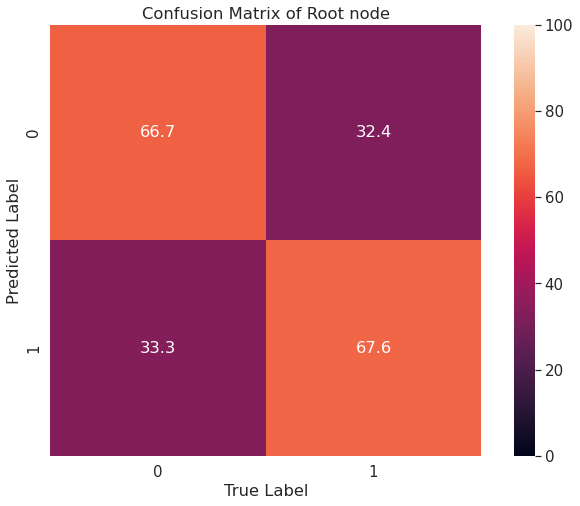

In [125]:
# Imposta il set di test e applica la smart labeling
binary_classifier.update_test_set(Xtest)
ytest, true_ytest = smart_labeling(ytest, level=0)

print(true_ytest[:20])

# Predizioni
ypred = binary_classifier.predict()
soft_ypred = binary_classifier.predict_proba()

# Metriche
print(classification_report(ytest, ypred))
score = accuracy_score(ytest, ypred, normalize=False)
print(f"Score (non normalizzato): {score}")

# Conteggio delle predizioni corrette e raccolta delle etichette 'Benign' corrette
ben_ytest = [true_ytest[i] for i, (yt, yp) in enumerate(zip(ytest, ypred)) if yt == yp == "Benign"]
accuracy = np.mean(np.array(ypred) == np.array(ytest))
print(f"Accuratezza: {accuracy:.4f}")

# Confusion matrix
mat = confusion_matrix(ytest, ypred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.set(font_scale=1.4)
sns.heatmap(mat.T * 100, square=True, annot=True, vmin=0, vmax=100, fmt='.1f', cbar=True)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of Root node')
plt.show()


#### Filtraggio delle quintuple (IMPORTANTE: per il blocco RO è questa la parte da modificare!)

In [126]:
#Qui ho quattro vettori con la stessa dimensione:
# - Xtest che è il vettore degli oggetti di classificazione
# - ytest che è il vettore delle classi di appartenenza
# - ypred che è il vettore delle predizione effettuate dal classificatore
# - true_ytest che è lo stesso di ytest, ma con l'etichetta estesa (Categoria_Famiglia in caso Malware)

cat_Xtest = []
cat_ytest = []

threshold = 0.5

for i in range(len(ypred)):
    if(ypred[i] == "Malware" and np.max(soft_ypred[i]) >= threshold):
        cat_Xtest.append(Xtest[i])
        cat_ytest.append(true_ytest[i])

print("Test del nodo Root")
print("Numero quintuple testate: " + str(len(ytest)))
print("Numero quintuple classificate come Malware: " + str(len(cat_ytest)))
print("Numero quintuple classificate come Benign: " + str(len(ytest) - len(cat_ytest)))

Test del nodo Root
Numero quintuple testate: 243755
Numero quintuple classificate come Malware: 124825
Numero quintuple classificate come Benign: 118930


### Estrazione dei dati - Livello categoria

In [127]:
# Training set per il nodo Malware e relative etichette
categories = ["Adware", "Ransomware", "Scareware", "SMSMalware"]
category_data, category_target = [], []

# Pre-elabora le categorie di ogni campione
train_categories = [label.split("_")[0] for label in true_ytrain]

# Mantiene solo i campioni appartenenti alle categorie Malware
for x, y, cat in zip(Xtrain, true_ytrain, train_categories):
    if cat in categories:
        category_data.append(x)
        category_target.append(y)

print(len(category_data))


382202


### Addestramento del classificatore Malware

In [128]:
#Labellazione smart per l'addestramento
cat_ytrain, cat_true_ytrain = smart_labeling(category_target, 1)

#Definizione e addestramento del classificatore
category_classifier = Classifier(category_data, cat_ytrain, "K-Nearest Neighbors")
category_classifier.fit()

### Testing del nodo Malware

#### Esecuzione

Numero di campioni in test: 124825
['Scareware_AVforandroid', 'SMSMalware_plankton', 'Adware_Shuanet', 'Adware_Shuanet', 'Adware_Ewind', 'Ransomware_LockerPin', 'Adware_Gooligan', 'Adware_Gooligan', 'SMSMalware_Nandrobox', 'SMSMalware_smssniffer', 'Benign', 'Adware_Ewind', 'Ransomware_WannaLocker', 'Scareware_FakeTaoBao', 'SMSMalware_smssniffer', 'Ransomware_Charger', 'Benign', 'Adware_Koodous', 'Benign', 'Benign']
              precision    recall  f1-score   support

      Adware       0.38      0.66      0.49     26637
  Ransomware       0.43      0.65      0.52     22659
  SMSMalware       0.38      0.45      0.41     14175
   Scareware       0.35      0.44      0.39     22600

   micro avg       0.39      0.56      0.46     86071
   macro avg       0.39      0.55      0.45     86071
weighted avg       0.39      0.56      0.46     86071

Accuratezza: 0.3889
Accuratezza (controllo): 0.3889
['Scareware', 'SMSMalware', 'Adware', 'Adware', 'Adware', 'Ransomware', 'Adware', 'Adware', 'S

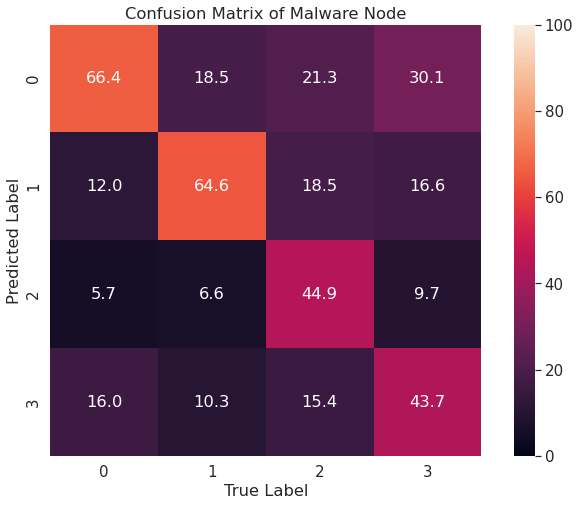

In [129]:
category_labels = ["Adware", "Ransomware", "SMSMalware", "Scareware"]
print(f"Numero di campioni in test: {len(cat_ytest)}")

# Aggiorna set di test e applica smart labeling
category_classifier.update_test_set(cat_Xtest)
cat_ytest, cat_true_ytest = smart_labeling(cat_ytest, level=1)

print(cat_true_ytest[:20])

# Predizioni
cat_ypred = category_classifier.predict()
soft_cat_ypred = category_classifier.predict_proba()

# Metriche di valutazione
print(classification_report(cat_ytest, cat_ypred, labels=category_labels))
score = accuracy_score(cat_ytest, cat_ypred)
print(f"Accuratezza: {score:.4f}")

# Accuratezza calcolata esplicitamente (stesso risultato di sopra)
accuracy = np.mean(np.array(cat_ypred) == np.array(cat_ytest))
print(f"Accuratezza (controllo): {accuracy:.4f}")

# Anteprima etichette
print(cat_ytest[:20])

# Matrice di confusione
mat = confusion_matrix(cat_ytest, cat_ypred, normalize='true', labels=category_labels)
plt.figure(figsize=(12, 8), dpi=70)
sns.set(font_scale=1.4)
sns.heatmap(mat.T * 100, square=True, annot=True, vmin=0, vmax=100, fmt='.1f', cbar=True)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of Malware Node')
plt.show()


#### Filtraggio delle quintuple

In [130]:
# Inizializza dizionario per categorie
category_tests = {
    "Adware": {"X": [], "y": []},
    "Ransomware": {"X": [], "y": []},
    "Scareware": {"X": [], "y": []},
    "SMSMalware": {"X": [], "y": []}
}

threshold = 0.8

# Filtra campioni con confidenza sufficiente
for x, y_true, y_pred, y_soft in zip(cat_Xtest, cat_true_ytest, cat_ypred, soft_cat_ypred):
    if np.max(y_soft) >= threshold and y_pred in category_tests:
        category_tests[y_pred]["X"].append(x)
        category_tests[y_pred]["y"].append(y_true)

# Estrai singole liste (compatibilità con codice successivo)
Ad_Xtest, Ad_ytest = category_tests["Adware"]["X"], category_tests["Adware"]["y"]
Ra_Xtest, Ra_ytest = category_tests["Ransomware"]["X"], category_tests["Ransomware"]["y"]
Sc_Xtest, Sc_ytest = category_tests["Scareware"]["X"], category_tests["Scareware"]["y"]
Sm_Xtest, Sm_ytest = category_tests["SMSMalware"]["X"], category_tests["SMSMalware"]["y"]

# Unisci tutte le etichette accettate
fam_ytest = Ad_ytest + Ra_ytest + Sc_ytest + Sm_ytest

# Report sintetico
print("Test del nodo Malware")
print(f"Numero quintuple testate: {len(cat_ytest)}")
print(f"Numero quintuple classificate correttamente: {len(fam_ytest)}")
print(f"Numero quintuple scartate: {len(cat_ytest) - len(fam_ytest)}")


Test del nodo Malware
Numero quintuple testate: 124825
Numero quintuple classificate correttamente: 47625
Numero quintuple scartate: 77200


#### Adware

In [131]:
# Partizionamento del training set per il nodo Adware
Adware_families = [
    "Dowgin", "Ewind", "Feiwo", "Gooligan", "Kemoge",
    "Koodous", "Mobidash", "Selfmite", "Shuanet", "Youmi"
]

fam_labels = Adware_families.copy()
Adware_data, Adware_target = [], []

# Nessun bilanciamento: prendi tutti i campioni delle famiglie Adware
for x, label in zip(category_data, cat_true_ytrain):
    if label.split("_")[1] in Adware_families:
        Adware_data.append(x)
        Adware_target.append(label)

print(f"Numero di campioni Adware: {len(Adware_data)}")


Numero di campioni Adware: 111783


#### Ransomware

In [132]:
# Nodo Ransomware
Ransomware_families = [
    "Charger", "Jisut", "Koler", "LockerPin", "Pletor",
    "PornDroid", "RansomBO", "Simplocker", "Svpeng", "WannaLocker"
]

fam_labels.extend(Ransomware_families)
Ransomware_data, Ransomware_target = [], []

# Nessun bilanciamento: prendi tutti i campioni appartenenti alle famiglie Ransomware
for x, label in zip(category_data, cat_true_ytrain):
    if label.split("_")[1] in Ransomware_families:
        Ransomware_data.append(x)
        Ransomware_target.append(label)

print(f"Numero di campioni Ransomware: {len(Ransomware_data)}")


Numero di campioni Ransomware: 95340


#### Scareware

In [133]:
# Nodo Scareware
Scareware_families = [
    "AndroidDefender", "AndroidSpy.277", "AVforandroid", "AVpass",
    "FakeApp", "FakeApp.AL", "FakeAV", "FakeJobOffer",
    "FakeTaoBao", "Penetho", "VirusShield"
]

Scareware_data, Scareware_target = [], []
fam_labels.extend(Scareware_families)

# Nessun bilanciamento: prendi tutti i campioni delle famiglie Scareware
for x, label in zip(category_data, cat_true_ytrain):
    if label.split("_")[1] in Scareware_families:
        Scareware_data.append(x)
        Scareware_target.append(label)

print(f"Numero di campioni Scareware: {len(Scareware_data)}")


Numero di campioni Scareware: 109274


#### SMS Malware

In [134]:
# Nodo SMSMalware
SMSMalware_families = [
    "Beanbot", "Biige", "fakeinst", "fakemart", "fakenotify",
    "jifake", "mazarbot", "Nandrobox", "plankton", "smssniffer", "zsone"
]

SMSMalware_data, SMSMalware_target = [], []
fam_labels.extend(SMSMalware_families)

# Nessun bilanciamento: prendi tutti i campioni delle famiglie SMSMalware
for x, label in zip(category_data, cat_true_ytrain):
    if label.split("_")[1] in SMSMalware_families:
        SMSMalware_data.append(x)
        SMSMalware_target.append(label)

print(f"Numero di campioni SMSMalware: {len(SMSMalware_data)}")


Numero di campioni SMSMalware: 65805


### Addestramento dei classificatori

#### Adware

In [135]:
#Labellazione smart per l'addestramento
Ad_ytrain, Ad_true_ytrain = smart_labeling(Adware_target, 2)

#Definizione e addestramento del classificatore
Adware_classifier = Classifier(Adware_data, Ad_ytrain, "K-Nearest Neighbors")
Adware_classifier.fit()

#### Ransomware

In [136]:
#Labellazione smart per l'addestramento
Ra_ytrain, Ra_true_ytrain = smart_labeling(Ransomware_target, 2)

#Definizione e addestramento del classificatore
Ransomware_classifier = Classifier(Ransomware_data, Ra_ytrain, "K-Nearest Neighbors")
Ransomware_classifier.fit()

#### Scareware

In [137]:
#Labellazione smart per l'addestramento
Sc_ytrain, Sc_true_ytrain = smart_labeling(Scareware_target, 2)

#Definizione e addestramento del classificatore
Scareware_classifier = Classifier(Scareware_data, Sc_ytrain, "K-Nearest Neighbors")
Scareware_classifier.fit()

#### SMS Malware

In [138]:
#Labellazione smart per l'addestramento
Sm_ytrain, Sm_true_ytrain = smart_labeling(SMSMalware_target, 2)

#Definizione e addestramento del classificatore
SMSMalware_classifier = Classifier(SMSMalware_data, Sm_ytrain, "K-Nearest Neighbors")
SMSMalware_classifier.fit()

### Testing dei nodi categoria

In [139]:
# Test delle famiglie figlie di Malware
family_nodes = {
    "Adware": ([], []),
    "Ransomware": ([], []),
    "Scareware": ([], []),
    "SMSMalware": ([], [])
}

threshold = 0.8  # soglia per confidence

for x, true_label, pred, soft_pred in zip(cat_Xtest, cat_true_ytest, cat_ypred, soft_cat_ypred):
    if np.max(soft_pred) >= threshold and pred in family_nodes:
        family_nodes[pred][0].append(x)           # X_test
        family_nodes[pred][1].append(true_label)  # y_test

# Estrazione dei singoli nodi se serve separatamente
Ad_Xtest, Ad_ytest = family_nodes["Adware"]
Ra_Xtest, Ra_ytest = family_nodes["Ransomware"]
Sc_Xtest, Sc_ytest = family_nodes["Scareware"]
Sm_Xtest, Sm_ytest = family_nodes["SMSMalware"]

# Tutte le quintuple confidenti insieme
fam_ytest = Ad_ytest + Ra_ytest + Sc_ytest + Sm_ytest

print("Test del nodo Malware")
print(f"Numero quintuple testate: {len(cat_ytest)}")
print(f"Numero quintuple confidenti: {len(fam_ytest)}")
print(f"Numero quintuple scartate: {len(cat_ytest) - len(fam_ytest)}")
print(f"Somma dei campioni per famiglie: {len(Ad_Xtest) + len(Ra_Xtest) + len(Sc_Xtest) + len(Sm_Xtest)}")


Test del nodo Malware
Numero quintuple testate: 124825
Numero quintuple confidenti: 47625
Numero quintuple scartate: 77200
Somma dei campioni per famiglie: 47625


#### Adware

Numero quintuple Adware: 16245
Prime 20 etichette Adware: ['Adware_Shuanet', 'Adware_Ewind', 'Adware_Gooligan', 'Benign', 'Adware_Ewind', 'Benign', 'Benign', 'Adware_Gooligan', 'Adware_Gooligan', 'Adware_Mobidash', 'Scareware_VirusShield', 'Scareware_AndroidDefender', 'Adware_Gooligan', 'Scareware_FakeApp', 'Adware_Gooligan', 'Adware_Gooligan', 'Adware_Mobidash', 'SMSMalware_Biige', 'Adware_Kemoge', 'Adware_Shuanet']
Numero quintuple dopo smart labeling: 16245
              precision    recall  f1-score   support

      Dowgin       0.29      0.71      0.41       848
       Ewind       0.23      0.58      0.33       807
       Feiwo       0.29      0.59      0.39      1133
    Gooligan       0.75      0.84      0.80      3676
      Kemoge       0.39      0.65      0.48       945
     Koodous       0.40      0.59      0.48       753
    Mobidash       0.15      0.24      0.18       470
    Selfmite       0.16      0.13      0.15       186
     Shuanet       0.26      0.39      0.31     

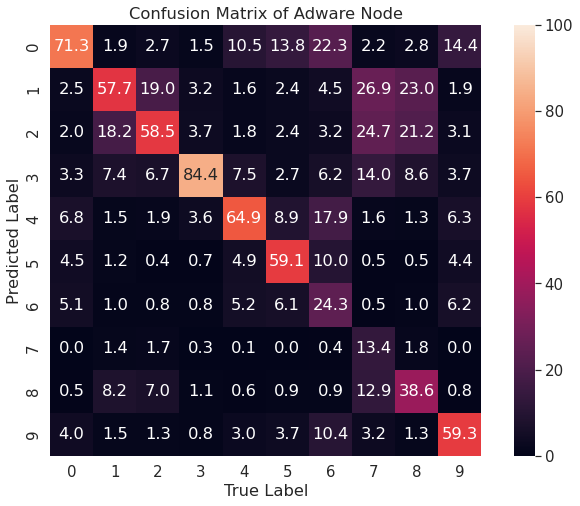

In [140]:
print(f"Numero quintuple Adware: {len(Ad_ytest)}")
print("Prime 20 etichette Adware:", Ad_ytest[0:20])

# Controllo rapido per errori
if "Adware" in Ad_ytest:
    print("Errore: etichette non dovrebbero essere 'Adware' a questo livello")

# Aggiornamento test set e smart labeling
Adware_classifier.update_test_set(Ad_Xtest)
Ad_ytest, Adware_true_ytest = smart_labeling(Ad_ytest, level=2)

print(f"Numero quintuple dopo smart labeling: {len(Ad_ytest)}")

# Predizione
Adware_ypred = Adware_classifier.predict()
fam_ypred = list(Adware_ypred)  # estendo il vettore delle predizioni

# Valutazione
score = accuracy_score(Ad_ytest, Adware_ypred)
print(classification_report(Ad_ytest, Adware_ypred, labels=Adware_families))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Ad_ytest, Adware_ypred, normalize='true', labels=Adware_families)
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat.T*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
sns.set(font_scale=1.4)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of Adware Node')
plt.show()


#### Ransomware

Numero quintuple Ransomware: 13968
Numero quintuple dopo smart labeling: 13968
              precision    recall  f1-score   support

     Charger       0.24      0.53      0.33      1057
       Jisut       0.16      0.31      0.21       489
       Koler       0.43      0.65      0.52      1413
   LockerPin       0.21      0.25      0.23       556
      Pletor       0.65      0.68      0.66       147
   PornDroid       0.50      0.64      0.56      1637
    RansomBO       0.25      0.45      0.32       855
  Simplocker       0.29      0.41      0.34       908
      Svpeng       0.53      0.66      0.59      1632
 WannaLocker       0.29      0.33      0.31       710

   micro avg       0.36      0.53      0.43      9404
   macro avg       0.35      0.49      0.41      9404
weighted avg       0.37      0.53      0.44      9404

Accuracy: 0.3572


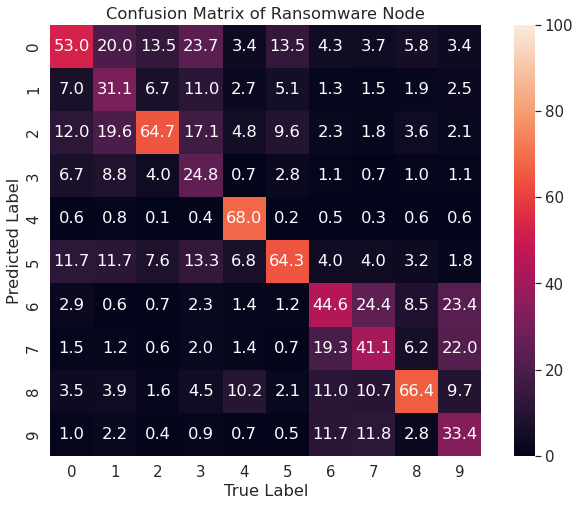

In [141]:
print(f"Numero quintuple Ransomware: {len(Ra_ytest)}")

# Aggiornamento test set e smart labeling
Ransomware_classifier.update_test_set(Ra_Xtest)
Ra_ytest, Ransomware_true_ytest = smart_labeling(Ra_ytest, level=2)

print(f"Numero quintuple dopo smart labeling: {len(Ra_ytest)}")

# Predizione
Ransomware_ypred = Ransomware_classifier.predict()
fam_ypred.extend(Ransomware_ypred)

# Valutazione
score = accuracy_score(Ra_ytest, Ransomware_ypred)
print(classification_report(Ra_ytest, Ransomware_ypred, labels=Ransomware_families))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Ra_ytest, Ransomware_ypred, normalize='true', labels=Ransomware_families)
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat.T*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
sns.set(font_scale=1.4)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of Ransomware Node')
plt.show()


#### Scareware

Numero quintuple Scareware: 11225
Numero quintuple dopo smart labeling: 11225
                 precision    recall  f1-score   support

AndroidDefender       0.39      0.79      0.53       934
 AndroidSpy.277       0.24      0.50      0.33       315
   AVforandroid       0.23      0.66      0.34       681
         AVpass       0.20      0.51      0.28       542
        FakeApp       0.20      0.38      0.26       300
     FakeApp.AL       0.32      0.52      0.39       676
         FakeAV       0.24      0.51      0.33       576
   FakeJobOffer       0.25      0.48      0.33       322
     FakeTaoBao       0.26      0.43      0.33       409
        Penetho       0.26      0.48      0.34       281
    VirusShield       0.42      0.60      0.50       413

      micro avg       0.28      0.57      0.37      5449
      macro avg       0.27      0.53      0.36      5449
   weighted avg       0.28      0.57      0.38      5449

Accuracy: 0.2759


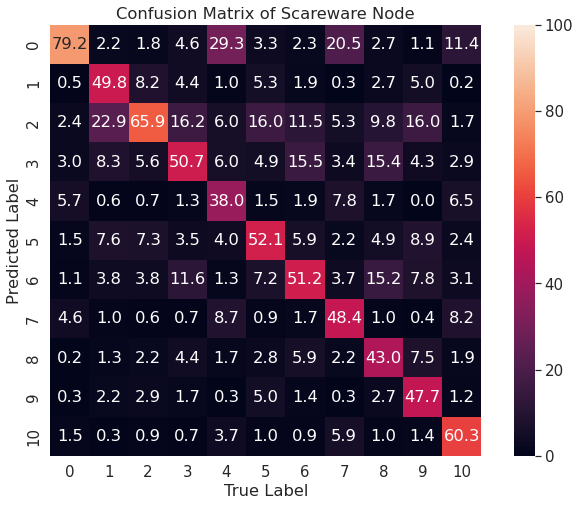

In [142]:
print(f"Numero quintuple Scareware: {len(Sc_ytest)}")

# Aggiornamento test set e smart labeling
Scareware_classifier.update_test_set(Sc_Xtest)
Sc_ytest, Scareware_true_ytest = smart_labeling(Sc_ytest, level=2)

print(f"Numero quintuple dopo smart labeling: {len(Sc_ytest)}")

# Predizione
Scareware_ypred = Scareware_classifier.predict()
fam_ypred.extend(Scareware_ypred)

# Valutazione
score = accuracy_score(Sc_ytest, Scareware_ypred)
print(classification_report(Sc_ytest, Scareware_ypred, labels=Scareware_families))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Sc_ytest, Scareware_ypred, normalize='true', labels=Scareware_families)
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat.T*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
sns.set(font_scale=1.4)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of Scareware Node')
plt.show()


#### SMSMalware

Numero quintuple SMSMalware: 6187
Prime 20 etichette: ['SMSMalware_Nandrobox', 'SMSMalware_plankton', 'Adware_Kemoge', 'SMSMalware_plankton', 'Benign', 'SMSMalware_mazarbot', 'SMSMalware_Biige', 'SMSMalware_fakeinst', 'SMSMalware_zsone', 'SMSMalware_plankton', 'SMSMalware_fakenotify', 'Benign', 'Benign', 'Scareware_AVpass', 'SMSMalware_Nandrobox', 'Benign', 'Scareware_FakeJobOffer', 'Benign', 'SMSMalware_fakenotify', 'SMSMalware_fakenotify']
Numero quintuple dopo smart labeling: 6187
              precision    recall  f1-score   support

     Beanbot       0.13      0.32      0.19        71
       Biige       0.32      0.74      0.45       310
    fakeinst       0.32      0.44      0.37       102
    fakemart       0.16      0.31      0.21        51
  fakenotify       0.33      0.48      0.39       611
      jifake       0.09      0.17      0.12        63
    mazarbot       0.43      0.54      0.48       105
   Nandrobox       0.40      0.65      0.50       887
    plankton       0.50 

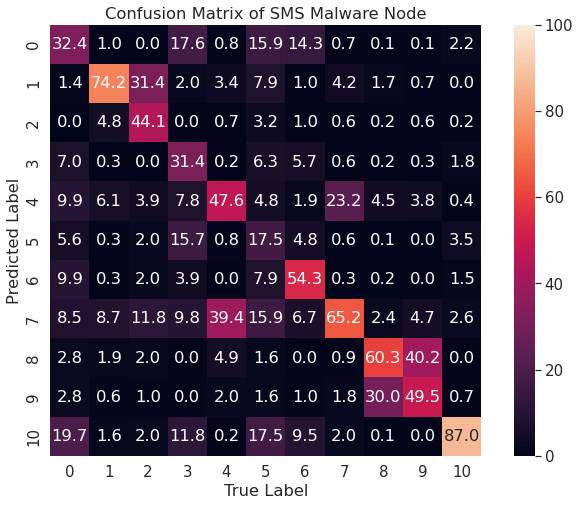

In [143]:
print(f"Numero quintuple SMSMalware: {len(Sm_ytest)}")
print("Prime 20 etichette:", Sm_ytest[0:20])

# Aggiornamento test set e smart labeling
SMSMalware_classifier.update_test_set(Sm_Xtest)
Sm_ytest, SMSMalware_true_ytest = smart_labeling(Sm_ytest, level=2)

print(f"Numero quintuple dopo smart labeling: {len(Sm_ytest)}")

# Predizione
SMSMalware_ypred = SMSMalware_classifier.predict()
fam_ypred.extend(SMSMalware_ypred)

# Valutazione
score = accuracy_score(Sm_ytest, SMSMalware_ypred)
print(classification_report(Sm_ytest, SMSMalware_ypred, labels=SMSMalware_families))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Sm_ytest, SMSMalware_ypred, normalize='true', labels=SMSMalware_families)
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat.T*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
sns.set(font_scale=1.4)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of SMS Malware Node')
plt.show()


In [144]:
print(fam_ypred[0:20])
fam_ytest, fam_true_ytest = smart_labeling(fam_ytest, 2)
print(fam_ytest[0:20])
print(fam_true_ytest[0:100])

print(fam_labels)

['Feiwo', 'Ewind', 'Gooligan', 'Ewind', 'Kemoge', 'Gooligan', 'Youmi', 'Kemoge', 'Gooligan', 'Gooligan', 'Dowgin', 'Kemoge', 'Gooligan', 'Ewind', 'Gooligan', 'Gooligan', 'Mobidash', 'Gooligan', 'Kemoge', 'Shuanet']
['Shuanet', 'Ewind', 'Gooligan', 'Benign', 'Ewind', 'Benign', 'Benign', 'Gooligan', 'Gooligan', 'Mobidash', 'VirusShield', 'AndroidDefender', 'Gooligan', 'FakeApp', 'Gooligan', 'Gooligan', 'Mobidash', 'Biige', 'Kemoge', 'Shuanet']
['Adware_Shuanet', 'Adware_Ewind', 'Adware_Gooligan', 'Benign', 'Adware_Ewind', 'Benign', 'Benign', 'Adware_Gooligan', 'Adware_Gooligan', 'Adware_Mobidash', 'Scareware_VirusShield', 'Scareware_AndroidDefender', 'Adware_Gooligan', 'Scareware_FakeApp', 'Adware_Gooligan', 'Adware_Gooligan', 'Adware_Mobidash', 'SMSMalware_Biige', 'Adware_Kemoge', 'Adware_Shuanet', 'Ransomware_WannaLocker', 'Adware_Gooligan', 'Scareware_FakeAV', 'Adware_Mobidash', 'Scareware_AndroidDefender', 'Benign', 'Benign', 'Scareware_AVforandroid', 'Scareware_FakeJobOffer', 'Benig

                 precision    recall  f1-score   support

         Dowgin       0.29      0.60      0.39      1006
          Ewind       0.23      0.44      0.30      1053
          Feiwo       0.29      0.46      0.36      1448
       Gooligan       0.75      0.78      0.77      3969
         Kemoge       0.39      0.53      0.45      1161
        Koodous       0.40      0.49      0.44       900
       Mobidash       0.15      0.18      0.16       641
       Selfmite       0.16      0.10      0.12       259
        Shuanet       0.26      0.28      0.27       853
          Youmi       0.45      0.49      0.47      1113
        Charger       0.24      0.46      0.32      1210
          Jisut       0.16      0.26      0.19       586
          Koler       0.43      0.58      0.49      1586
      LockerPin       0.21      0.21      0.21       661
         Pletor       0.65      0.61      0.63       164
      PornDroid       0.50      0.59      0.54      1798
       RansomBO       0.25    

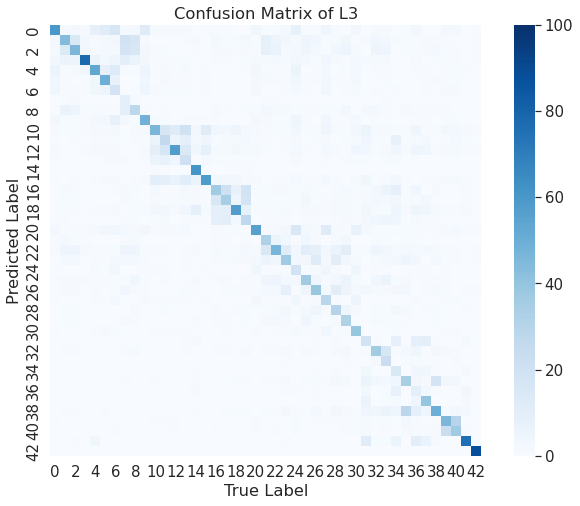

In [145]:
# Costruzione delle etichette complete del livello famiglia
fam_labels = Adware_families + Ransomware_families + Scareware_families + SMSMalware_families
fam_labels.append("Benign")

# Smart labeling delle istanze Benign
ben_ytest, ben_true_ytest = smart_labeling(ben_ytest, level=2)

# Aggiungo i dati Benign ai vettori finali
for i in range(len(ben_ytest)):
    fam_ytest.append(ben_ytest[i])
    fam_ypred.append("Benign")

# Valutazione complessiva
score = accuracy_score(fam_ytest, fam_ypred)
print(classification_report(fam_ytest, fam_ypred, labels=fam_labels))
print(f"Accuracy complessiva: {score:.4f}")

# Confusion matrix finale
mat = confusion_matrix(fam_ytest, fam_ypred, normalize='true', labels=fam_labels)
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat.T*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True, cmap='Blues')
sns.set(font_scale=1.4)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix of L3')
plt.show()
